# Data Analysis

The following notebook is the data analysis used in the post on CSGO skins and economy. This notebook will follow that same order for organizational sake. Keep note many of the techniques I used may not be the most efficient. Feel free to improve upon what I have done!

In [308]:
# general imports needed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from datetime import date, timedelta
from math import exp
%matplotlib inline

idx = pd.IndexSlice

In [2]:
skins = pd.read_excel("datasets/all_skins.xlsx", header = [0,1], index_col = 0)
skins = skins.drop(labels = "2020-09-14", axis = 1) # 9/14/2020 data was not complete so dropped to preserve accuracy

# created a copy of skins as loading the file can take too long
# accidental changes to the dataframe can be reverted through this clean copy

skins_copy = skins.copy()

In [165]:
stickers = pd.read_excel("datasets/all_stickers.xlsx", header = [0,1], index_col = 0)
stickers = stickers.drop(labels = "2020-09-14", axis = 1) # 9/14/2020 data was not complete so dropped to preserve accuracy

In [167]:
others = pd.read_excel("datasets/all_others.xlsx", header = [0,1], index_col = 0)
others = others.drop(labels = "2020-09-14", axis = 1)

In [6]:
# generating a basic dataframe to store calculated values
skins_data = skins.loc[:,["Weapon", "Collection", "Quality", "Skin", "Condition", "StatTrak", "Souvenir"]]

skins_data.columns = skins_data.columns.droplevel(1) #dropping the second level created for the multiindex

In [7]:
# dataframe of just skins and knives for easier data analysis
skins_price = skins.loc[:, idx[:, "Price"]]
skins_price.columns = skins_price.columns.droplevel(1)
skins_price.columns = pd.to_datetime(skins_price.columns)
skins_price

,2013-08-01,2013-08-02,2013-08-03,2013-08-04,2013-08-05,2013-08-06,2013-08-07,2013-08-08,2013-08-09,2013-08-10,...,2020-09-04,2020-09-05,2020-09-06,2020-09-07,2020-09-08,2020-09-09,2020-09-10,2020-09-11,2020-09-12,2020-09-13
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.627000,NaN,0.855000,1.089000,1.012000
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.555000,NaN,0.490000,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.327625,0.453875,0.523000,0.497563,0.460000,0.478187,0.456000,0.628047,0.400000,0.522000
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.734000,0.827000,0.834000,0.807000,0.874000,0.780000,0.821000,0.777000,0.812625,0.745000
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.115750,1.315000,1.156750,1.167000,NaN,NaN,1.080000,1.102500,1.147750,1.092000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10276,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,99.035250,94.789750,104.314000,103.724000,98.191500,103.652375,96.189000,103.997000,95.311000,101.277000
10277,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,105.099500,93.859500,100.792000,97.992750,98.424500,95.089250,105.708000,106.870000,NaN,104.022250
10278,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,93.864594,103.006438,96.488969,100.806250,101.696438,103.107250,100.482938,99.109773,104.087446,100.290398
10279,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,136.953500,139.497000,119.080000,139.493500,133.385500,134.215875,124.767000,131.277000,141.769000,120.625000


In [8]:
# dataframe of skin prices with no knives included
skins_price_g = skins.loc[:, idx[:, "Price"]]
skins_price_g.insert(loc = 0, value = skins["Quality"], column = "Quality")
skins_price_g = skins_price_g[(skins_price_g["Quality"] != "Extraordinary") & (skins_price_g["Quality"] != "Covert")]
skins_price_g = skins_price_g.drop(columns = ["Quality"], axis = 1)
skins_price_g.columns = skins_price_g.columns.droplevel(1)
skins_price_g.columns = pd.to_datetime(skins_price_g.columns)
skins_price_g

C:\Users\William Huang\miniconda3\envs\datascience\lib\site-packages\pandas\core\generic.py:3878: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


,2013-08-01,2013-08-02,2013-08-03,2013-08-04,2013-08-05,2013-08-06,2013-08-07,2013-08-08,2013-08-09,2013-08-10,...,2020-09-04,2020-09-05,2020-09-06,2020-09-07,2020-09-08,2020-09-09,2020-09-10,2020-09-11,2020-09-12,2020-09-13
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.627000,NaN,0.855000,1.089000,1.012
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.555,NaN,0.490000,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.327625,0.453875,0.52300,0.497563,0.460,0.478187,0.456,0.628047,0.400000,0.522
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.734000,0.827000,0.83400,0.807000,0.874,0.780000,0.821,0.777000,0.812625,0.745
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.115750,1.315000,1.15675,1.167000,NaN,NaN,1.080,1.102500,1.147750,1.092
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7270,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,409.030000,434.467,NaN,NaN,NaN
7271,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7272,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,511.720000,NaN,488.08000,451.680000,NaN,NaN,NaN,NaN,NaN,NaN
7273,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,613.505000,NaN,NaN,NaN,NaN,501.000000,NaN


In [9]:
# dataframe of skin prices with covert/gloves only included
skins_price_kg = skins.loc[:, idx[:, "Price"]]
skins_price_kg.insert(loc = 0, value = skins["Quality"], column = "Quality")
skins_price_kg = skins_price_kg[(skins_price_kg["Quality"] == "Extraordinary") | (skins_price_kg["Quality"] == "Covert")]
skins_price_kg = skins_price_kg.drop(columns = ["Quality"], axis = 1)
skins_price_kg.columns = skins_price_kg.columns.droplevel(1)
skins_price_kg.columns = pd.to_datetime(skins_price_kg.columns)
skins_price_kg

C:\Users\William Huang\miniconda3\envs\datascience\lib\site-packages\pandas\core\generic.py:3878: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


,2013-08-01,2013-08-02,2013-08-03,2013-08-04,2013-08-05,2013-08-06,2013-08-07,2013-08-08,2013-08-09,2013-08-10,...,2020-09-04,2020-09-05,2020-09-06,2020-09-07,2020-09-08,2020-09-09,2020-09-10,2020-09-11,2020-09-12,2020-09-13
191,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.484281,4.626250,4.416000,4.541000,4.682203,NaN,4.632750,4.495687,4.699750,4.780000
192,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.440000,7.257500,NaN,NaN,6.981000,NaN,NaN,6.810000,NaN,6.747500
193,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.339823,4.361812,4.626961,4.651113,4.359448,4.743819,4.399578,4.415102,4.514632,4.587083
194,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.869125,6.102344,6.215523,5.632000,5.680063,5.439479,5.614883,5.631332,5.508922,5.636793
195,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8.582750,9.131812,9.016078,9.268500,9.514375,9.394250,9.380500,9.569000,9.057688,8.117500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10276,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,99.035250,94.789750,104.314000,103.724000,98.191500,103.652375,96.189000,103.997000,95.311000,101.277000
10277,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,105.099500,93.859500,100.792000,97.992750,98.424500,95.089250,105.708000,106.870000,NaN,104.022250
10278,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,93.864594,103.006438,96.488969,100.806250,101.696438,103.107250,100.482938,99.109773,104.087446,100.290398
10279,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,136.953500,139.497000,119.080000,139.493500,133.385500,134.215875,124.767000,131.277000,141.769000,120.625000


In [10]:
# dataframe of just volumes for easier data analysis
skins_vol = skins.loc[:, idx[:, "Volume"]]
skins_vol.columns = skins_vol.columns.droplevel(1)
skins_vol.columns = pd.to_datetime(skins_vol.columns)
skins_vol

,2013-08-01,2013-08-02,2013-08-03,2013-08-04,2013-08-05,2013-08-06,2013-08-07,2013-08-08,2013-08-09,2013-08-10,...,2020-09-04,2020-09-05,2020-09-06,2020-09-07,2020-09-08,2020-09-09,2020-09-10,2020-09-11,2020-09-12,2020-09-13
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2.0,NaN,4.0,1.0,2.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,1.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.0,4.0,2.0,7.0,1.0,6.0,1.0,10.0,1.0,5.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,2.0,2.0,1.0,2.0,1.0,2.0,5.0,2.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,2.0,3.0,2.0,NaN,NaN,3.0,2.0,3.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10276,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,5.0,2.0,1.0,2.0,4.0,3.0,2.0,3.0,3.0
10277,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,2.0,2.0,4.0,2.0,3.0,1.0,1.0,NaN,3.0
10278,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9.0,8.0,7.0,3.0,10.0,6.0,5.0,9.0,16.0,11.0
10279,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,2.0,1.0,2.0,2.0,4.0,3.0,1.0,3.0,1.0


# Basic Calculations

Used to get a general overview of the composition of the weapon skin economy

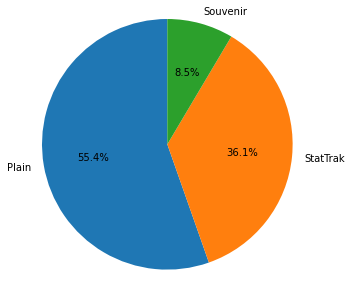

In [767]:
# getting count of stattrak, souvenir, and plain skins
st = len(skins[skins["StatTrak", "Unnamed: 6_level_1"] == True])
sv = len(skins[skins["Souvenir", "Unnamed: 7_level_1"] == True])
plain = len(skins) - st - sv

fig1, ax1 = plt.subplots()
fig1.set_size_inches(5,5)
ax1.pie([plain, st, sv], labels = ["Plain", "StatTrak", "Souvenir"], autopct = "%1.1F%%", startangle = 90)
ax1.axis("equal")
# plt.savefig("graphs/stsvpl.png", bbox_inches = "tight")

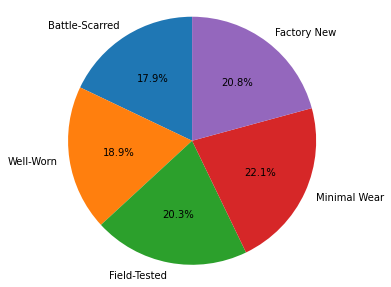

In [768]:
# count of different conditions
conditions = skins["Condition", "Unnamed: 5_level_1"].value_counts()
conditions = conditions.reindex(index = ["Battle-Scarred", "Well-Worn", "Field-Tested", "Minimal Wear", "Factory New"])
fig1, ax1 = plt.subplots()
fig1.set_size_inches(5,5)
ax1.pie(conditions, labels = conditions.index, autopct = "%1.1F%%", startangle = 90)
ax1.axis("equal")
# plt.savefig("graphs/conditions.png", bbox_inches = "tight")

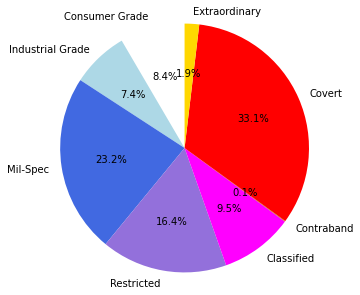

In [6]:
# count of the qualities
qualities = skins["Quality", "Unnamed: 3_level_1"].value_counts()
qualities = qualities.reindex(index = ["Consumer Grade", "Industrial Grade", "Mil-Spec", "Restricted", "Classified", "Contraband", "Covert", "Extraordinary"])
colors = ["white","lightblue", "royalblue", "mediumpurple", "magenta","darkgoldenrod", "red", "gold"]
fig1, ax1 = plt.subplots()
fig1.set_size_inches(5,5)
ax1.pie(qualities, labels = qualities.index, autopct = "%1.1F%%", colors = colors, startangle = 90)
ax1.axis("equal")
# plt.savefig("graphs/qualities.png", bbox_inches = "tight")

In [90]:
skins_data["AVG Price"] = skins_price.mean(axis = 1)

In [701]:
skins_data["AVG Price"].mean()

80.5092499331008

In [702]:
skins_data["AVG Price"].std()

169.59245732642603

In [87]:
skins_data["AVG Daily Volume"] = skins_vol.mean(axis = 1)

In [704]:
skins_data["AVG Daily Volume"].mean()

81.60888995071481

In [705]:
skins_data["AVG Daily Volume"].std()

197.94414434867207

In [710]:
# volume weighted average price
np.nansum((skins_price.mul(skins_vol)).values)/ np.nansum(skins_vol.values)

2.026007909316107

In [212]:
skins_data["Total Vol"] = skins_vol.apply(lambda row: np.nansum(row), axis = 1)

In [263]:
skins_data["First Date Sold"] = skins_price.apply(lambda row: pd.Series.first_valid_index(row), axis = 1)

In [233]:
# calculating the daily volume sold 
vol_daily = skins_vol.apply(lambda column: np.nansum(column))
vol_daily.index = vol_daily.index.droplevel(1)
vol_daily = vol_daily.reset_index()
vol_daily["index"] = pd.to_datetime(vol_daily["index"])
vol_daily.columns = ["Date", "Vol"]

vol_daily = vol_daily[(vol_daily["Vol"] != 0)] # removing empty days at the start

vol_daily

,Date,Vol
12,2013-08-13,4.0
13,2013-08-14,87.0
14,2013-08-15,6998.0
15,2013-08-16,17072.0
16,2013-08-17,21164.0
...,...,...
2596,2020-09-09,584624.0
2597,2020-09-10,576704.0
2598,2020-09-11,619819.0
2599,2020-09-12,678882.0


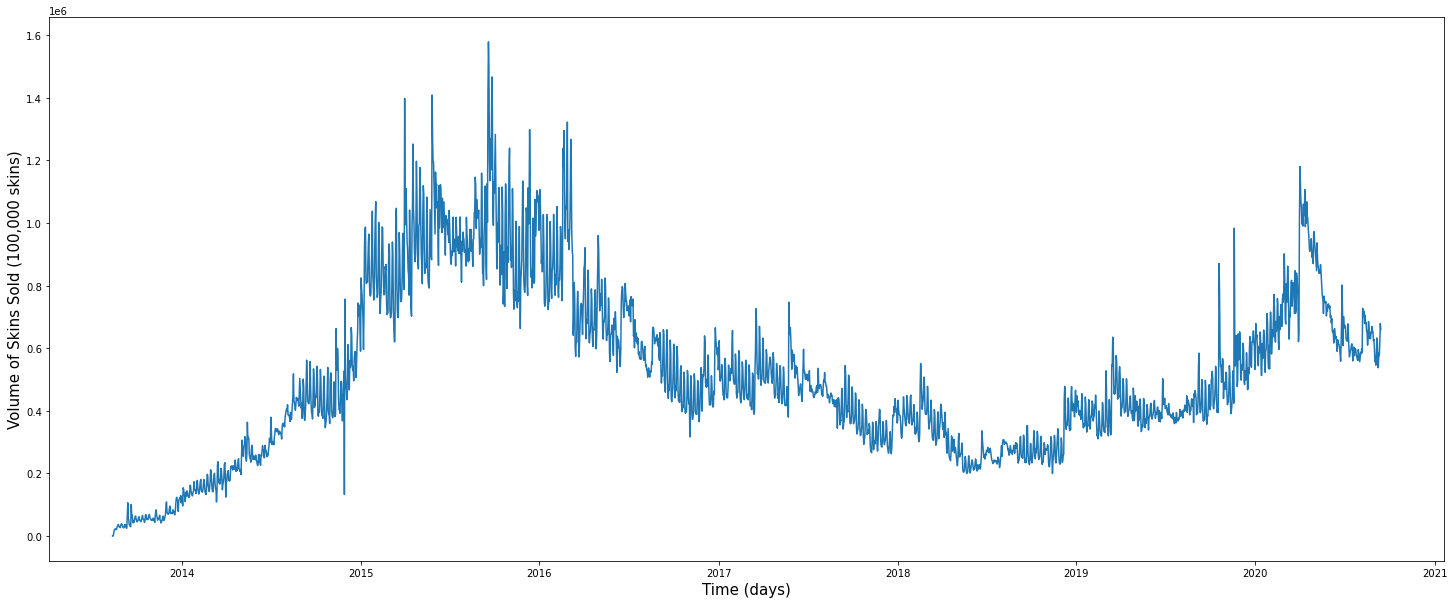

In [235]:
# unused graph of the volume of skins sold per day
plt.figure(figsize = (25,10))
plt.plot(vol_daily["Date"], vol_daily["Vol"])
plt.xlabel("Time (days)", size = 15)
plt.ylabel("Volume of Skins Sold (100,000 skins)", size = 15)
# plt.savefig("graphs/dailyvol_time.png")

# Appreciation Calculations

Different analyses used to analyze how much a skin appreciates

In [335]:
# these delete all the prior NaN values and make it so each skin starts from 0 days from release up
appreciation_dates = skins_price.apply(lambda x: pd.Series(x.loc[x.first_valid_index():].values), axis = 1)
appreciation_dates_g = skins_price_g.apply(lambda x: pd.Series(x.loc[x.first_valid_index():].values), axis = 1)
appreciation_dates_kg = skins_price_kg.apply(lambda x: pd.Series(x.loc[x.first_valid_index():].values), axis = 1)

In [336]:
# gets the last date sold 9-13-2020
last_dates = skins_price.fillna(method = "ffill", axis = 1)["2020-09-13"] # forward fill to take the last date sold's price
last_dates_g = skins_price_g.fillna(method = "ffill", axis = 1)["2020-09-13"]
last_dates_kg = skins_price_g.fillna(method = "ffill", axis = 1)["2020-09-13"]

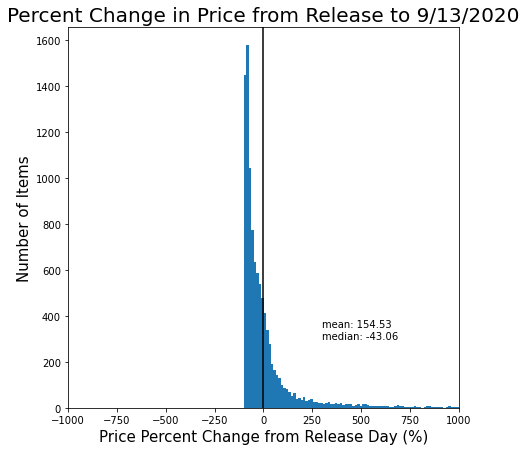

In [12]:
# average appreciation from day 1
app = ((last_dates.sub(appreciation_dates[0])).div(appreciation_dates[0], axis = 0) * 100)
plt.figure(figsize = (7, 7))
plt.xlim(-1000, 1000)
plt.xlabel("Price Percent Change from Release Day (%)", size = 15)
plt.ylabel("Number of Items", size =15)
plt.title("Percent Change in Price from Release to 9/13/2020", size = 20)
plt.hist(app, bins = 40000)
plt.annotate(text = "mean: {}\nmedian: {}".format(round(app.mean(), 2), round(app.median(), 2)) ,xy = (300, 300))
plt.axvline(0, color = "black")
plt.savefig("graphs/appreleasenow.png")

In [341]:
# percent change from day 1
decrease_1 = (((appreciation_dates.div(appreciation_dates[0], axis = 0)) * 100).mean()).rolling(20).mean()
decrease_2 = (((appreciation_dates_g.div(appreciation_dates_g[0], axis = 0)) * 100).mean()).rolling(20).mean()
decrease_3 = (((appreciation_dates_kg.div(appreciation_dates_kg[0], axis = 0)) * 100).mean()).rolling(20).mean()

[0.03973982] 41.16324299868559 0.42438989595533516


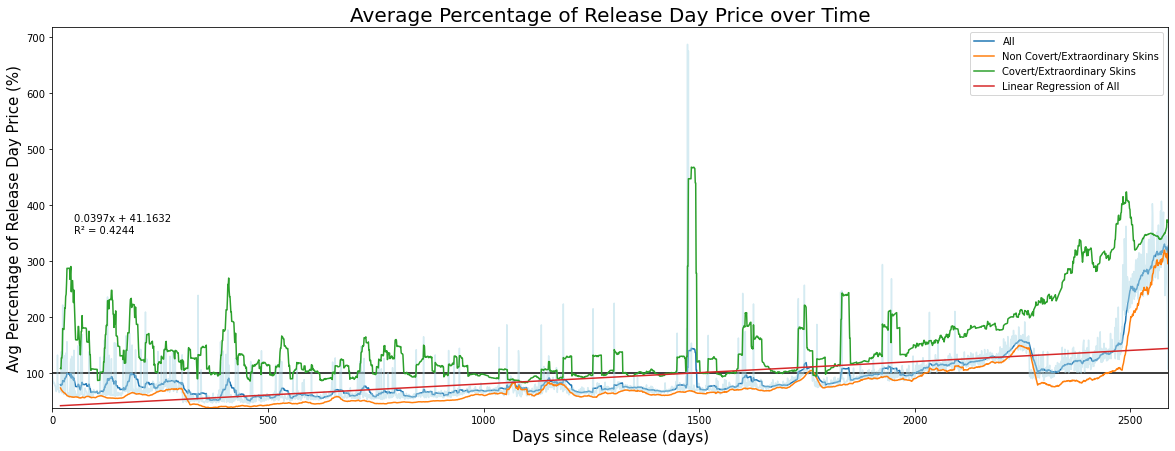

In [342]:
# Price over time as a percentage of release date price. 
plt.figure(figsize = (20,7))
plt.margins(0)
plt.axhline(100, color = "black")
plt.xlabel("Days since Release (days)", size = 15)
plt.ylabel("Avg Percentage of Release Day Price (%)", size = 15)
plt.title("Average Percentage of Release Day Price over Time", size = 20)
#plt.xlim(left = 0, right = 100)
#plt.ylim(bottom = -50, top = 5)
plt.plot(decrease_1, label = "All")
plt.plot(decrease_2, label = "Non Covert/Extraordinary Skins")
plt.plot(decrease_3, label = "Covert/Extraordinary Skins")

#linear regression
y = np.array(decrease_1.dropna())
x = np.array(decrease_1.dropna().index).reshape((-1,1))

model = LinearRegression().fit(x,y)
print(model.coef_, model.intercept_, model.score(x,y))
x_coord = decrease_1.dropna().index
y_coord = model.coef_[0] * x + model.intercept_
plt.annotate(text = f"{round(model.coef_[0],4)}x + {round(model.intercept_, 4)}\nR² = {round(model.score(x,y), 4)}", xy = (50, 350))
plt.plot(x_coord, y_coord, label = "Linear Regression of All")

plt.legend()
# plt.savefig("graphs/percentchangeall3.png")

In [127]:
# mean value of non covert/extraordinary 1 year after release
decrease_2[:365].mean()

58.82707437482656

In [213]:
# getting the slope of the linear regression
def lin_reg(row):
    try:
        x = np.array(row.dropna().index).reshape((-1,1))
        y = np.array(row.dropna())

        model = LinearRegression().fit(x, y)

        return model.coef_[0]
    except:
        pass

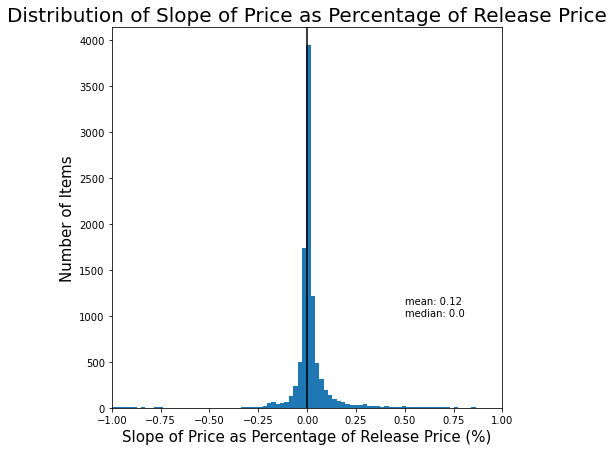

In [52]:
# plot of the slopes of linear regression
m = ((appreciation_dates.div(appreciation_dates[0], axis = 0))*100).apply(lambda row: lin_reg(row), axis = 1) # applying linear regression for each row
plt.figure(figsize = (7, 7))
plt.xlabel("Slope of Price as Percentage of Release Price (%)", size = 15)
plt.ylabel("Number of Items", size =15)
plt.title("Distribution of Slope of Price as Percentage of Release Price", size = 20)
plt.annotate(text = "mean: {}\nmedian: {}".format(round(m.mean(), 2), round(m.median(), 2)) ,xy = (.5, 1000))
plt.axvline(0, color = "black")
plt.hist(m, bins = 15000)
plt.xlim(-1, 1)

# plt.savefig("graphs/appslope.png")

In [20]:
m.mean()

0.12370253149920647

In [54]:
# percentage of skins with positive slope
len(m.where(m>0).dropna())/len(m)

0.5752358719968874

# WHEN TO BUY IN

Calculating the minimum price and other metrics

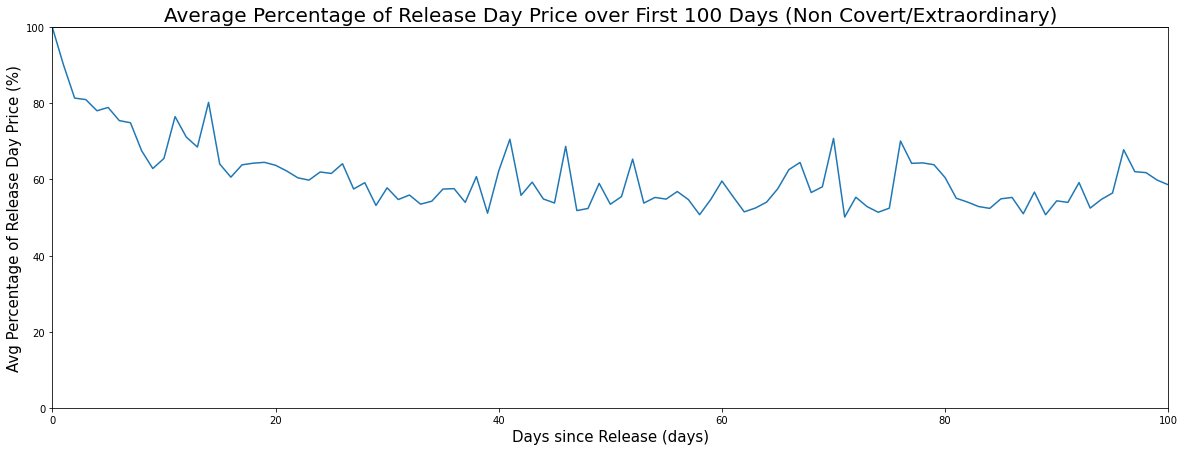

In [126]:
# plotting first 100 days
decrease = (((appreciation_dates_g.div(appreciation_dates_g[0], axis = 0)) * 100).mean())
plt.figure(figsize = (20,7))
plt.margins(0)
plt.axhline(100, color = "black")
plt.xlabel("Days since Release (days)", size = 15)
plt.ylabel("Avg Percentage of Release Day Price (%)", size = 15)
plt.title("Average Percentage of Release Day Price over First 100 Days (Non Covert/Extraordinary)", size = 20)
plt.xlim(left = 0, right = 100)
plt.ylim(bottom = 0, top = 100)
plt.plot(decrease)

plt.savefig("graphs/percentchangeskins100days.png")

[-0.10658279] 256.1949297298719 0.7580319790507419


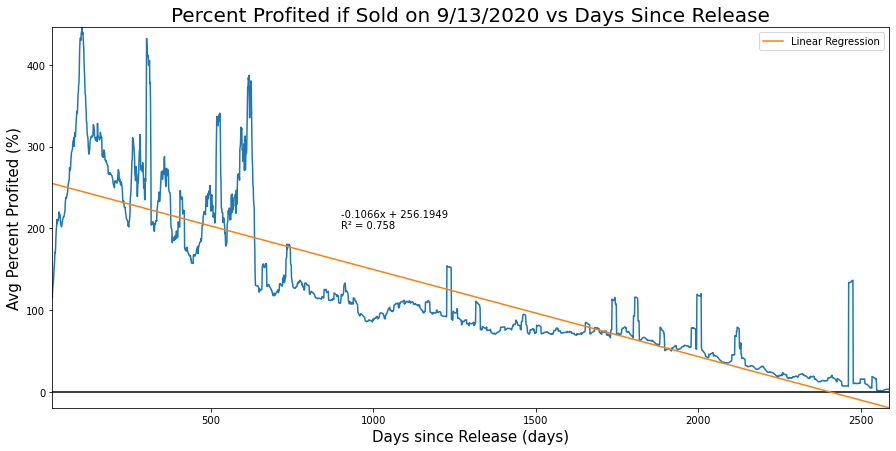

In [254]:
# calculating potential profits if bought and held to this day
# defunct and removed
profits = (-appreciation_dates.sub(last_dates, axis = 0).div(appreciation_dates) * 100).mean().rolling(14).mean()

y = np.array(profits.dropna())
x = np.array(profits.dropna().index).reshape((-1,1))

# linear regression
model = LinearRegression().fit(x,y)
print(model.coef_, model.intercept_, model.score(x,y))
x_coord = profits.dropna().index
y_coord = model.coef_[0] * x + model.intercept_

plt.figure(figsize = (20,7))
plt.plot(profits)
plt.margins(0)
plt.axhline(0, color = "black")
plt.plot(x_coord, y_coord, label = "Linear Regression")
plt.xlabel("Days since Release (days)", size = 15)
plt.ylabel("Avg Percent Profited (%)", size = 15)
plt.title("Percent Profited if Sold on 9/13/2020 vs Days Since Release", size = 20)
plt.annotate(text = f"{round(model.coef_[0],4)}x + {round(model.intercept_, 4)}\nR² = {round(model.score(x,y), 4)}", xy = (900, 200))
plt.legend()

# plt.savefig("graphs/percentgain.png")

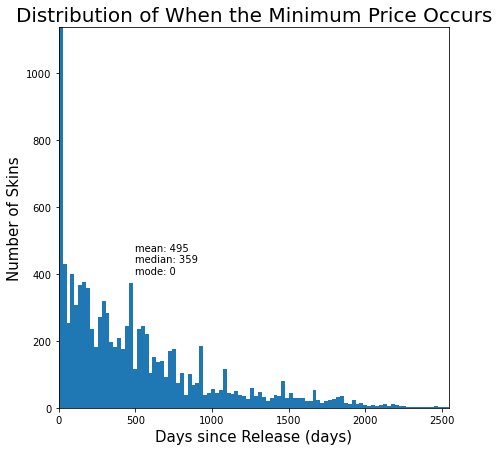

In [58]:
# calculating best possible day to buy in and hold
price_min = appreciation_dates.idxmin(axis = 1)
plt.figure(figsize = (7, 7))
plt.margins(0)
annotation = f"mean: {round(price_min.mean())}\nmedian: {round(price_min.median())} \nmode: {round(price_min.mode()[0])}"
plt.annotate(text = annotation, xy = (500, 400))
plt.xlabel("Days since Release (days)", size = 15)
plt.ylabel("Number of Skins", size = 15)
plt.title("Distribution of When the Minimum Price Occurs", size = 20)
plt.hist(price_min, bins = 100)

# plt.savefig("graphs/distributionofminimum.png")

In [184]:
len(price_min.where(price_min == ).dropna()) / len(price_min)

0.045909930940569985

In [195]:
price_min.std()

479.5601155307209

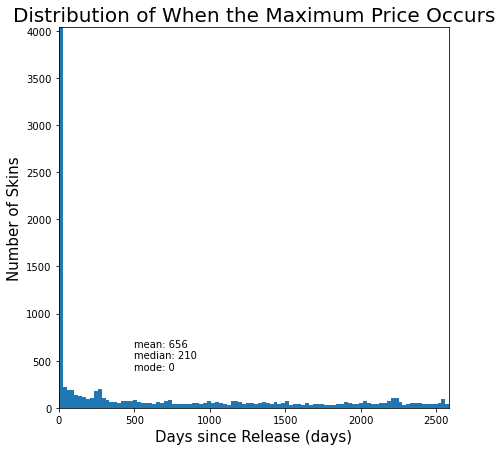

In [55]:
# calculating best possible day to sell
price_max = appreciation_dates.idxmax(axis = 1)
plt.figure(figsize = (7, 7))
plt.margins(0)
annotation = f"mean: {round(price_max.mean())}\nmedian: {round(price_max.median())} \nmode: {round(price_max.mode()[0])}"
plt.annotate(text = annotation, xy = (500, 400))
plt.xlabel("Days since Release (days)", size = 15)
plt.ylabel("Number of Skins", size = 15)
plt.title("Distribution of When the Maximum Price Occurs", size = 20)
plt.hist(price_max, bins = 100)

# plt.savefig("graphs/distributionofmaximum.png")

In [192]:
price_max.mean()

820.4203931151801

In [205]:
# counting how many items had a max per day after release day
price_max.where(price_max != 0).value_counts().mean()

7.825208426166139

In [196]:
# mean without release day
price_max.where(price_max != 0).mean()

907.268578352181

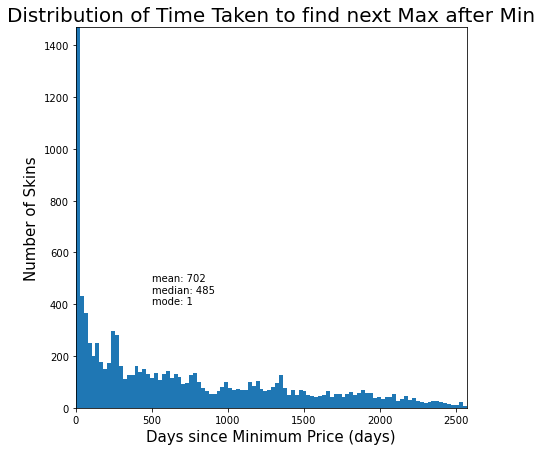

In [59]:
# calculating how much time to wait before selling after buying on minimum
def when_to_sell(row):
    index_min = row.idxmin()
    try:
        return row.iloc[index_min:].idxmax()
    except:
        return
time_sell = appreciation_dates.apply(lambda row: when_to_sell(row), axis = 1) - price_min

plt.figure(figsize = (7, 7))
plt.margins(0)
annotation = f"mean: {round(time_sell.mean())}\nmedian: {round(time_sell.median())} \nmode: {round(time_sell.mode()[0])}"
plt.annotate(text = annotation, xy = (500, 400))
plt.xlabel("Days since Minimum Price (days)", size = 15)
plt.ylabel("Number of Skins", size = 15)
plt.title("Distribution of Time Taken to find next Max after Min", size = 20)
plt.hist(time_sell, bins = 100)

# plt.savefig("graphs/timetaketofindmax.png")

In [241]:
time_sell.std()

676.6294559367823

In [250]:
# amount of items to wait over 1 year to sell
len(time_sell.where(time_sell>365).dropna())/len(time_sell)

0.5644392568816263

# VOLATILITY MEASUREMENTS

Volatility primarily focuses on STD.

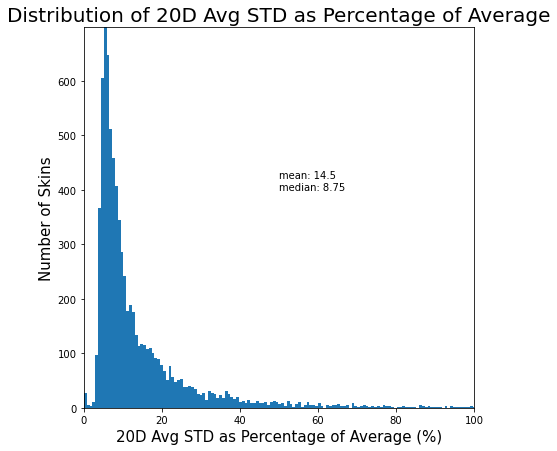

In [78]:
std_20d = skins_price.rolling(window = 20, axis = 1).std() # 20 day rolling standard deviation
m_20d = skins_price.rolling(window = 20, axis =1).mean() # 20 day rolling mean

std = (std_20d.div(m_20d)*100).mean(axis = 1) # standard deviation as a percentage of the rolling mean

plt.figure(figsize = (7, 7))
plt.margins(0)
annotation = f"mean: {round(std.mean(), 2)}\nmedian: {round(std.median(), 2)}"
plt.annotate(text = annotation, xy = (50, 400))
plt.xlabel("20D Avg STD as Percentage of Average (%)", size = 15)
plt.ylabel("Number of Skins", size = 15)
plt.title("Distribution of 20D Avg STD as Percentage of Average", size = 20)
plt.xlim(0, 100)
plt.hist(std, bins = 500)
# plt.savefig("graphs/20dstd.png")

In [81]:
skins_data["20dSTD"] = std 

In [79]:
std.std()

17.063195508206974

# Swing Trading

In [84]:
# amount of items you could theoretically make a profit on by using volatility
len(std.where(std > 8.105).dropna())/ len(std)

0.40881237233732126

In [107]:
skins_data[(skins_data["20dSTD"] > .8105) & (skins_data["AVG Daily Volume"] > 100) & (skins_data["AVG Price"] > .5)]

,Weapon,Collection,Quality,Skin,Condition,StatTrak,Souvenir,20dSTD,AVG Daily Volume,AVG Price
17,CZ75-Auto,The Bank Collection,Mil-Spec,Tuxedo,Factory New,False,0.0,8.609905,104.886549,0.635820
29,CZ75-Auto,The Chop Shop Collection,Mil-Spec,Emerald,Factory New,False,0.0,6.616608,129.560145,3.379023
38,CZ75-Auto,CS:GO Weapon Case 3,Mil-Spec,Crimson Web,Minimal Wear,False,0.0,11.753727,135.619127,1.048506
42,CZ75-Auto,CS:GO Weapon Case 3,Mil-Spec,Crimson Web,Field-Tested,True,0.0,14.242401,106.832848,1.170344
63,CZ75-Auto,Huntsman Weapon Case,Mil-Spec,Twist,Minimal Wear,True,0.0,10.830547,153.982502,0.707150
...,...,...,...,...,...,...,...,...,...,...
7236,Negev,Fracture Case,Mil-Spec,Ultralight,Factory New,False,0.0,20.904148,102.868421,0.918989
7239,Negev,Fracture Case,Mil-Spec,Ultralight,Field-Tested,True,0.0,25.392182,139.000000,0.602058
7262,Negev,Clutch Case,Restricted,Lionfish,Field-Tested,False,0.0,3.633681,260.670563,0.543004
7263,Negev,Clutch Case,Restricted,Lionfish,Minimal Wear,False,0.0,4.065078,184.918172,0.868940


## 20d STD AVG vs AVG Price
### UNUSED

<Figure size 1080x1080 with 0 Axes>

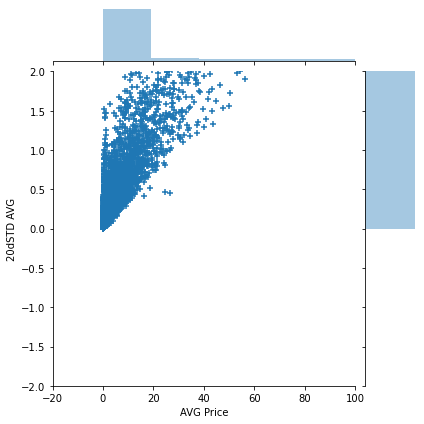

In [118]:
plt.figure(figsize = (15,15))
sns.jointplot(x = skins_data["AVG Price"], y = skins_data["20dSTD AVG"], dropna = True, xlim = (-20, 100), ylim = (-2, 2), marker = "+")

<Figure size 1080x1080 with 0 Axes>

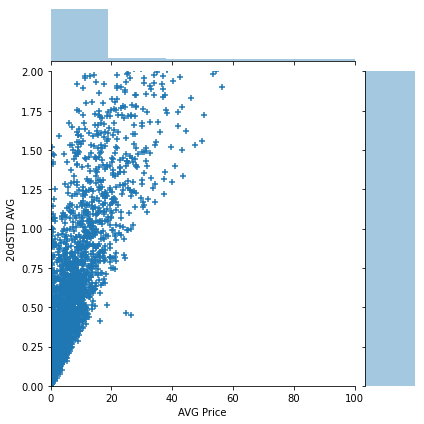

In [134]:
plt.figure(figsize = (15,15))
sns.jointplot(x = skins_data["AVG Price"], y = skins_data["20dSTD AVG"], dropna = True, xlim = (0, 100), ylim = (0, 2), marker = "+")

# Discontinued Items

In [109]:
# howl 6-11-2014
dates_list = [(date(2014, 6, 11) + timedelta(days = i)).strftime("%Y-%m-%d") for i in range(-30, 30)]
hwl = skins[skins["Skin", "Unnamed: 4_level_1"] == "Howl"].loc[:, idx[dates_list, "Price"]].mean().values

In [110]:
# griffin 12-9-2014
dates_list = [(date(2014, 12, 9) + timedelta(days = i)).strftime("%Y-%m-%d") for i in range(-30, 30)]
grif = skins[skins["Skin", "Unnamed: 4_level_1"] == "Griffin"].loc[:, idx[dates_list, "Price"]].mean().values

In [111]:
# dualies retribution 6-11-2014
dates_list = [(date(2014, 6, 11) + timedelta(days = i)).strftime("%Y-%m-%d") for i in range(-30, 30)]
retr = skins[(skins["Skin", "Unnamed: 4_level_1"] == "Retribution") & (skins["StatTrak", "Unnamed: 6_level_1"] == True)].loc[:, idx[dates_list, "Price"]].mean().values

In [112]:
# p90 desert warfare 6-11-2014
dates_list = [(date(2014, 6, 11) + timedelta(days = i)).strftime("%Y-%m-%d") for i in range(-30, 30)]
deswar = skins[(skins["Skin", "Unnamed: 4_level_1"] == "Desert Warfare") & (skins["StatTrak", "Unnamed: 6_level_1"] == True)].loc[:, idx[dates_list, "Price"]].mean().values

In [113]:
# cz75 poison dart 6-11-2014
dates_list = [(date(2014, 6, 11) + timedelta(days = i)).strftime("%Y-%m-%d") for i in range(-30, 30)]
poidart = skins[(skins["Skin", "Unnamed: 4_level_1"] == "Poison Dart") & (skins["StatTrak", "Unnamed: 6_level_1"] == True)].loc[:, idx[dates_list, "Price"]].mean().values

In [114]:
# mac10 curse 6-11-2014
dates_list = [(date(2014, 6, 11) + timedelta(days = i)).strftime("%Y-%m-%d") for i in range(-30, 30)]
curse = skins[(skins["Skin", "Unnamed: 4_level_1"] == "Curse") & (skins["StatTrak", "Unnamed: 6_level_1"] == True)].loc[:, idx[dates_list, "Price"]].mean().values

In [115]:
# usps orion 6-11-2014
dates_list = [(date(2014, 6, 11) + timedelta(days = i)).strftime("%Y-%m-%d") for i in range(-30, 30)]
orion = skins[(skins["Skin", "Unnamed: 4_level_1"] == "Orion") & (skins["StatTrak", "Unnamed: 6_level_1"] == True)].loc[:, idx[dates_list, "Price"]].mean().values

In [116]:
# mp5 labrats curse 1-9-2019
dates_list = [(date(2019, 1, 9) + timedelta(days = i)).strftime("%Y-%m-%d") for i in range(-30, 30)]
labrats = skins[(skins["Skin", "Unnamed: 4_level_1"] == "Lab Rats")].loc[:, idx[dates_list, "Price"]].mean().values

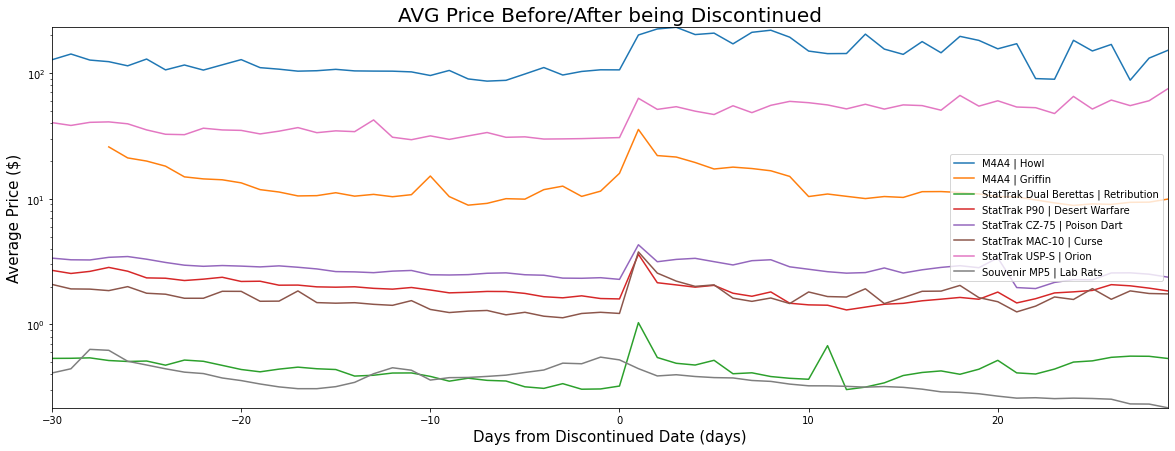

In [140]:
# price before and after controversy/discontinued
plt.figure(figsize = (20,7))
plt.margins(0)
plt.xlabel("Days from Discontinued Date (days)", size = 15)
plt.ylabel("Average Price ($)", size = 15)
plt.title("AVG Price Before/After being Discontinued", size = 20)
plt.yscale("log")
i = 0
discontinued = ["M4A4 | Howl", "M4A4 | Griffin", "StatTrak Dual Berettas | Retribution", "StatTrak P90 | Desert Warfare"
                , "StatTrak CZ-75 | Poison Dart", "StatTrak MAC-10 | Curse", "StatTrak USP-S | Orion", "Souvenir MP5 | Lab Rats"]
for x in (hwl, grif, retr, deswar, poidart, curse, orion, labrats):
    plt.plot([i for i in range(-30, 30)], x, label= discontinued[i])
    i += 1
    

plt.legend()
# plt.savefig("graphs/discontinued.png")

In [133]:
avg_p_b = []
avg_p_a = []

swing = []
for x in (hwl, grif, retr, deswar, poidart, curse, orion, labrats):
    before = np.nanmean(x[0:30])
    after = np.nanmean(x[31:60])
    s = x[31]/x[30]
    avg_p_b.append(before)
    avg_p_a.append(after)
    swing.append(s)
avg_p_b = pd.Series(avg_p_b) # avg price before discontinued
avg_p_a = pd.Series(avg_p_a) # avg price after being discontinued
swing = pd.Series(swing) # change on discontinued date

In [138]:
swing.mean()

2.183282386344227

In [139]:
swing.std()

0.7374608137453497

# Skin Index

In [18]:
# summing how many unique items sold per day
total_items = []
for day, values in skins_vol.iteritems():
    total_items.append(len(values.dropna()))
  
total_items = np.array(total_items)

In [19]:
daily_avg_price = skins_price.mean()
daily_avg_vol = (skins_vol.sum()).div(total_items)

index = daily_avg_price*daily_avg_vol

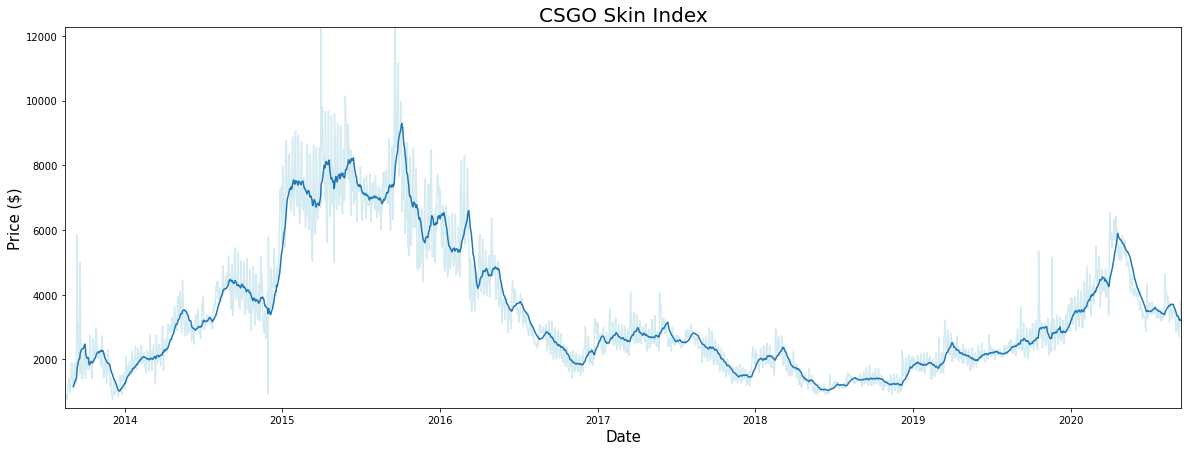

In [344]:
# graphing the index
plt.figure(figsize = (20,7))
plt.plot(index[15:], color = "lightblue", alpha = .5)
plt.plot(index[15:].rolling(window=20).mean())
plt.margins(0)
plt.xlabel("Date", size = 15)
plt.ylabel("Price ($)", size = 15)
plt.title("CSGO Skin Index", size = 20)

# plt.savefig("graphs/skinindex.png")

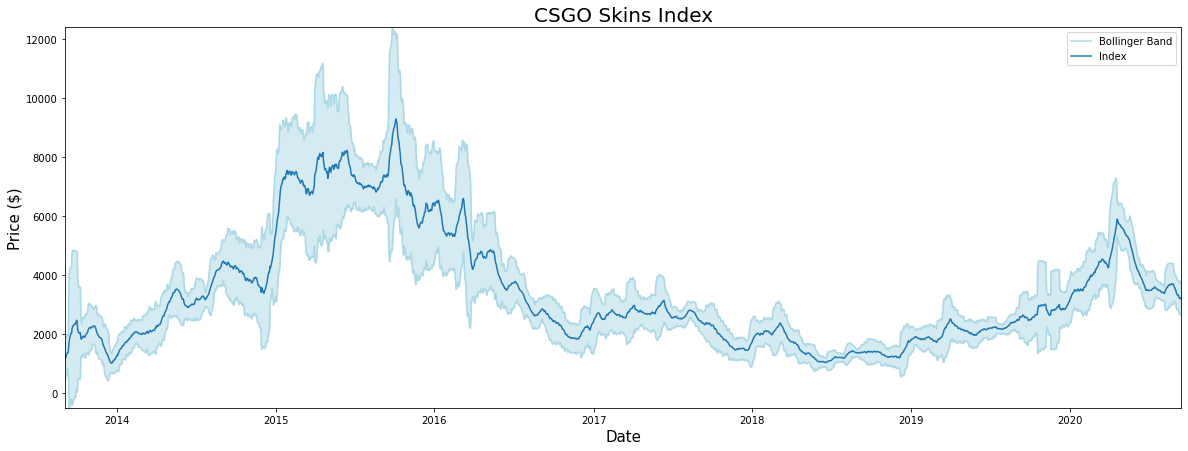

In [72]:
# bollinger bands
plt.figure(figsize = (20,7))
rolling_index = index[15:].rolling(window=20).mean()
rolling_std = index[15:].rolling(window = 20).std()
upper = rolling_index + 2 * rolling_std # upper bollinger band
lower = rolling_index - 2 * rolling_std # lower bollinger band
plt.plot(upper, color = "lightblue", label = "Bollinger Band")
plt.plot(lower, color = "lightblue")
plt.fill_between(upper.index, upper, lower, alpha = .5, color = "lightblue")
plt.plot(rolling_index, label = "Index")
plt.margins(0)
plt.xlabel("Date", size = 15)
plt.ylabel("Price ($)", size = 15)
plt.title("CSGO Skins Index", size = 20)
plt.legend()

# plt.savefig("graphs/skinindexavg.png")

In [91]:
# gambling ban price drop
(index["2016-07-11"] - index["2016-07-10"])/index["2016-07-10"]

-0.21742045970584273

# Steam Summer Sales

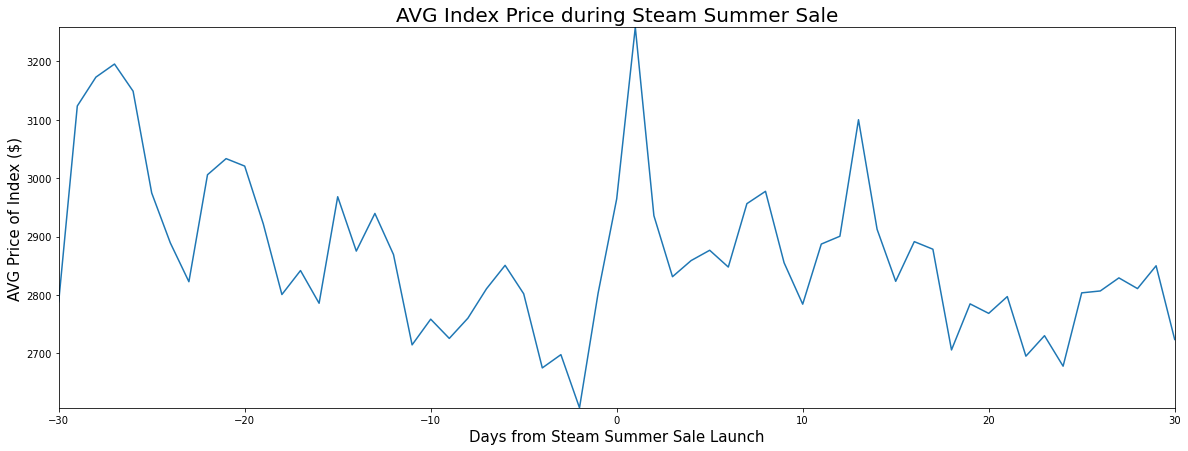

In [162]:
# steam summer sales
plt.figure(figsize = (20,7))
values = pd.DataFrame(columns = [x for x in range(-30, 31)])
sales = [date(2020, 6, 25), date(2019, 6, 25), date(2018, 6, 21), date(2017,6,22), date(2016,6,23), date(2016,6,11), date(2014, 6, 29)]
for sale_date in sales:
    begin = (sale_date - timedelta(days = 30)).strftime("%Y-%m-%d")
    end = (sale_date + timedelta(days = 30)).strftime("%Y-%m-%d")
    sale_time = index[begin:end]
    sale_time.index = values.columns
    values = values.append(sale_time, ignore_index = True)
plt.margins(0)
plt.xlabel("Days from Steam Summer Sale Launch", size = 15)
plt.ylabel("AVG Price of Index ($)", size = 15)
plt.title("AVG Index Price during Steam Summer Sale", size = 20)   
plt.plot(values.mean())
plt.savefig("graphs/summersale.png")

In [164]:
# percent change due to the summer sale starting
((values[2]-values[-1])/(values[-1]))

0    0.153656
1    0.184008
2    0.240898
3    0.022840
4   -0.032865
5   -0.150345
6    0.136899
dtype: float64

# Stickers

In [170]:
qualities = stickers["Quality", "Unnamed: 3_level_1"].value_counts()

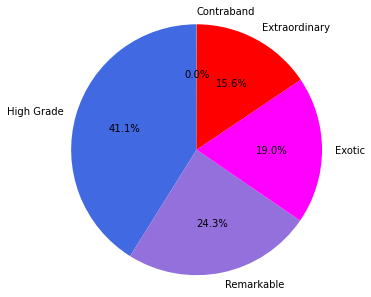

In [173]:
# count of the qualities
colors = ["royalblue", "mediumpurple", "magenta", "red", "goldenrod"]
fig1, ax1 = plt.subplots()
fig1.set_size_inches(5,5)
ax1.pie(qualities, labels = qualities.index, autopct = "%1.1F%%", colors = colors, startangle = 90)
ax1.axis("equal")
# plt.savefig("graphs/stickqualities.png", bbox_inches = "tight")

In [182]:
tourney = stickers[stickers["Collection", 'Unnamed: 2_level_1'].str.contains("20")] # all stickers with 20 in name
tourney = tourney[(tourney["Collection", "Unnamed: 2_level_1"] != "Community Stickers Halloween 2014") & (tourney["Collection", "Unnamed: 2_level_1"] != "Community Capsule 2018")] # removing the non tourney ones

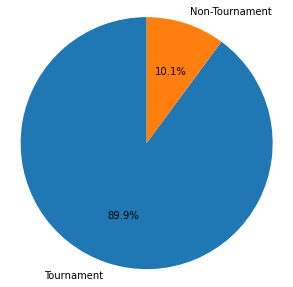

In [190]:
# ploting tourney stickers
fig1, ax1 = plt.subplots()
fig1.set_size_inches(5,5)
ax1.pie([len(tourney), len(stickers)-len(tourney)], labels = ["Tournament", "Non-Tournament"], autopct = "%1.1F%%", startangle = 90)
ax1.axis("equal")

# plt.savefig("graphs/sticktourney.png", bbox_inches = "tight")

In [206]:
# dataframes of price and volume for easier analysis
stick_price = stickers.loc[:, idx[:, "Price"]]
tourney_price = tourney.loc[:, idx[:, "Price"]]
stick_vol = stickers.loc[:, idx[:, "Volume"]]
tourney_vol = tourney.loc[:, idx[:, "Volume"]]

for x in (stick_price, tourney_price, stick_vol, tourney_vol):
    x.columns = x.columns.droplevel(1)
    x.columns = pd.to_datetime(x.columns)

In [193]:
# avg sticker market price
stick_price.mean(axis = 1).mean()

16.837015320049847

In [195]:
stick_vol.mean(axis = 1).mean()

164.08705610872317

In [209]:
# VWAP of stickers
np.nansum((stick_price.mul(stick_vol)).values)/ np.nansum(stick_vol.values)

0.7957253783312109

In [211]:
# dataframe with all stickers starting from 0 days since release
stick_appreciation = stick_price.apply(lambda x: pd.Series(x.loc[x.first_valid_index():].values), axis = 1)

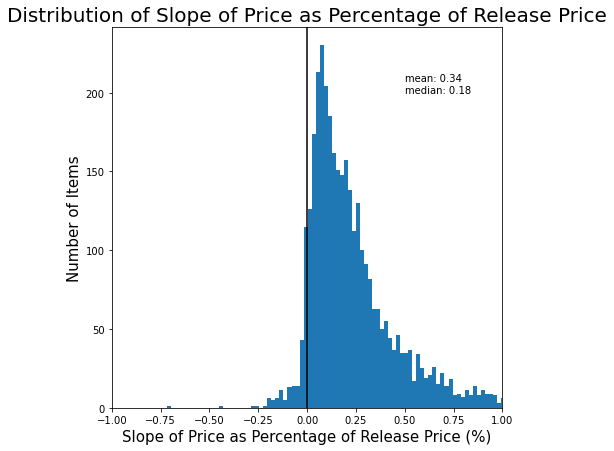

In [219]:
# graphing appreciation of stickers
m = ((stick_appreciation.div(stick_appreciation[0], axis = 0))*100).apply(lambda row: lin_reg(row), axis = 1)
plt.figure(figsize = (7, 7))
plt.xlabel("Slope of Price as Percentage of Release Price (%)", size = 15)
plt.ylabel("Number of Items", size =15)
plt.title("Distribution of Slope of Price as Percentage of Release Price", size = 20)
plt.annotate(text = "mean: {}\nmedian: {}".format(round(m.mean(), 2), round(m.median(), 2)) ,xy = (.5, 200))
plt.axvline(0, color = "black")
plt.hist(m, bins = 1000)
plt.xlim(-1, 1)

# plt.savefig("graphs/stickappslope.png")

In [222]:
# amount of stickers with positive slope
len(m.where(m > 0).dropna())/len(m)

0.9386111111111111

In [224]:
sticker_data = stickers.loc[:,["Weapon", "Collection", "Quality", "Skin", "Condition", "StatTrak", "Souvenir"]]

sticker_data.columns = sticker_data.columns.droplevel(1) #dropping the second level created for the multiindex

In [225]:
sticker_data["Slope"] = m

In [236]:
# splitting up stickers by collection to see average slope of each
collections = pd.Series()
for name, group in sticker_data.groupby(by = "Collection", axis = 0):
    collections.at[name] = float(group["Slope"].mean())

collections = collections.sort_values(ascending = False)
collections

<ipython-input-236-24717a04db0e>:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  collections = pd.Series()


# Cases

In [248]:
# dataframes for easier analysis
cases = others[others["Weapon", "Unnamed: 1_level_1"] == "Skin Cases"]
case_price = cases.loc[:, idx[:, "Price"]]
case_vol = cases.loc[:, idx[:, "Volume"]]

In [257]:
case_price.mean(axis = 1).std()

2.634050375275265

In [262]:
case_vol.mean(axis = 1)

11     1189.547316
12      191.993345
13     1318.917287
14     1802.336262
15     2445.759539
16     5221.582047
17     2093.674564
18    29758.408674
19    11731.817010
20    36746.160565
21     6064.239150
22     8881.569822
23    18879.228805
24    39774.090450
25    24034.513416
26    20051.518092
27    13316.630884
28    14908.056852
29    51289.858838
30    29486.656572
31    67594.361559
32    45042.377345
33    36647.174355
34     4294.258678
35    51234.081130
36    60203.954352
37    35501.029716
38    57889.519260
39    57023.059783
40    31087.996689
41       59.404011
42    59913.669670
43    56471.309524
44    47298.564103
dtype: float64

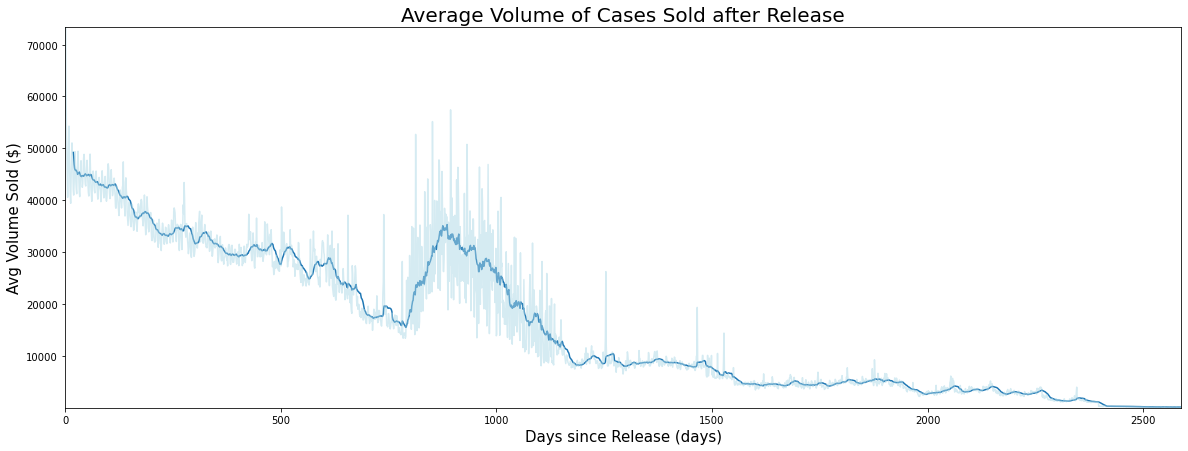

In [334]:
# graphing case price over time
case_appreciation_vol = case_vol.apply(lambda x: pd.Series(x.loc[x.first_valid_index():].values), axis = 1) # calculating case by indexing from 0 days since release
plt.figure(figsize = (20,7))
plt.xlabel("Days since Release (days)", size = 15)
plt.ylabel("Avg Volume Sold ($)", size = 15)
plt.title("Average Volume of Cases Sold after Release", size = 20)
plt.plot(case_appreciation_vol.mean().rolling(window=20).mean())
plt.plot(case_appreciation_vol.mean(), alpha = .5, color = "lightblue")
plt.margins(0)

# plt.savefig("graphs/volumecases.png")

In [265]:
# prices index by time since release date
case_appreciation_dates = case_price.apply(lambda x: pd.Series(x.loc[x.first_valid_index():].values), axis = 1)

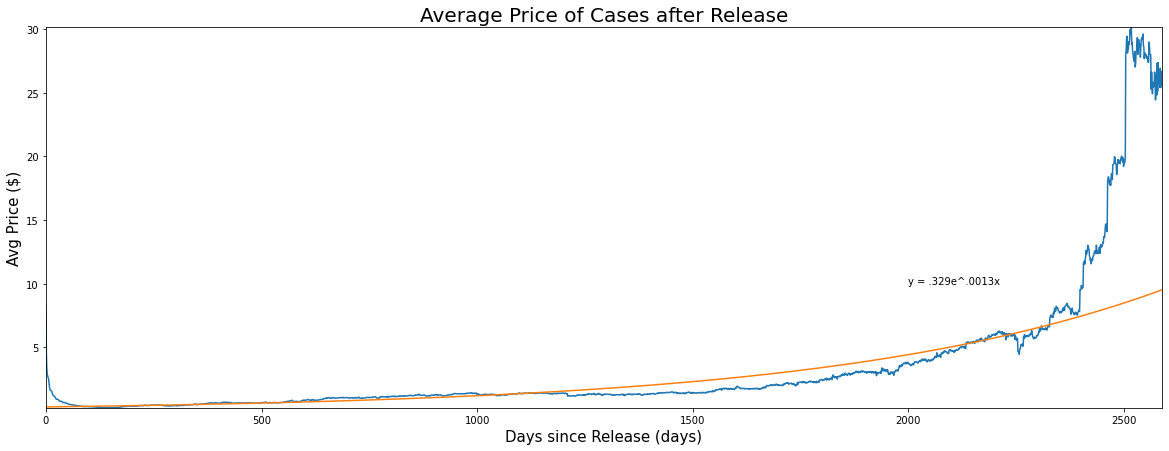

In [316]:
# graphing price after release
data = case_appreciation_dates.mean()
plt.figure(figsize = (20,7))
plt.margins(0)
plt.xlabel("Days since Release (days)", size = 15)
plt.ylabel("Avg Price ($)", size = 15)
plt.title("Average Price of Cases after Release", size = 20)
plt.plot(data)

y = case_appreciation_dates.dropna().mean().values
x = case_appreciation_dates.columns.values

# calculate exp regression
def exp_line(x):
    y = .329 * exp(.0013 * x)
    return y
new_y = []

for i in range(0,2589):
    new_y.append(exp_line(i))
    
plt.plot(x, new_y)
plt.annotate(text = "y = .329e^.0013x" ,xy = (2000, 10))
# plt.savefig("graphs/caseprice.png")

In [273]:
# time it takes to go above release price
data.where(data > 8.28399).dropna()

0        8.284000
2365     8.299333
2366     8.346000
2367     8.423000
2368     8.457833
          ...    
2584    26.900473
2585    25.387933
2586    25.795640
2587    26.672497
2588    26.326000
Length: 197, dtype: float64

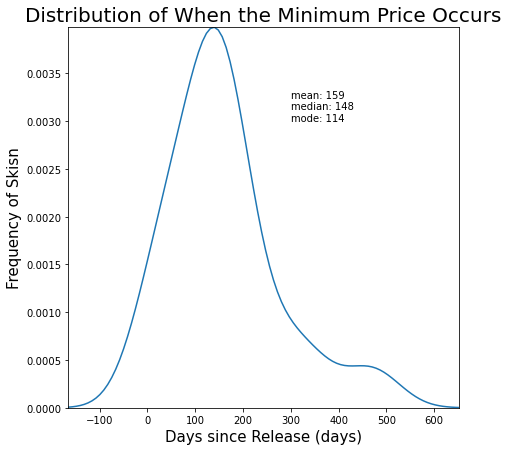

In [343]:
# calculating best possible day to buy in and hold
price_min = case_appreciation_dates.idxmin(axis = 1)
plt.figure(figsize = (7, 7))
plt.margins(0)
annotation = f"mean: {round(price_min.mean())}\nmedian: {round(price_min.median())} \nmode: {round(price_min.mode()[0])}"
plt.annotate(text = annotation, xy = (300, .003))
plt.xlabel("Days since Release (days)", size = 15)
plt.ylabel("Frequency of Skisn", size = 15)
plt.title("Distribution of When the Minimum Price Occurs", size = 20)
sns.kdeplot(price_min)

# plt.savefig("graphs/casedistributionofminimum.png")